In [ ]:
# Part 1

In [4]:
import cv2
import numpy as np
import random
from scipy.spatial.distance import cdist

class match:
    def get_match(self, gray_left, gray_right, verbose=False):
        
        def get_avg_residual(model, matches):
            def augment(data):
                aug_data = np.ones((len(data), 3), dtype=np.float64)
                aug_data[:,:2] = data
                return aug_data
            x, x_p = augment(matches[:,0]), augment(matches[:,1])
            # print(model.params)
            # print(x_p)

            result = model @ x.T
            result /= result[-1]
            result = result.transpose(1, 0)
            return np.mean(result - x_p)
        
        sift = cv2.xfeatures2d.SIFT_create()
        
        left_keypoints, left_neighborhood_list = sift.detectAndCompute(gray_left,None)
        right_keypoints, right_neighborhood_list = sift.detectAndCompute(gray_right,None)
        dist = cdist(left_neighborhood_list, right_neighborhood_list, 'sqeuclidean')
        
        putative_match = self.stable_match(dist, t=5000)
        left_keypoints = np.array([left_keypoints[idx].pt for idx in putative_match[0]])
        right_keypoints = np.array([right_keypoints[idx].pt for idx in putative_match[1]])
        
        indices = np.stack((left_keypoints, right_keypoints), axis=1).astype("uint64")
        
        
        # H, s = cv2.findHomography(indices[:,0], indices[:,1], cv2.RANSAC, 4)
        H, inlier_idxs = self.ransac_homography(indices[:, [1,0]], threshold=5, max_iterations=1000)
        print("Average inliers residual :" , get_avg_residual(H, indices[inlier_idxs]))
        print("Num of inliers :", len(inlier_idxs))
        
        if verbose:
            import matplotlib.pyplot as plt
            from skimage.feature import plot_matches
            fig, ax =plt.subplots(nrows=1, ncols=1)
            plot_matches(ax, gray_left, gray_right, indices[:, 0, [1, 0]], indices[:, 1, [1, 0]],\
                         np.column_stack((np.arange(indices.shape[0]), np.arange(indices.shape[0]))), matches_color='r')
            plt.title("Putative Matches")        
            fig, ax =plt.subplots(nrows=1, ncols=1)
            plot_matches(ax, gray_left, gray_right, indices[:, 0, [1, 0]], indices[:, 1, [1, 0]],
                         np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
            plt.title("Inliers")
        
        return H, inlier_idxs
    
    def stable_match(self, dist, t=2000):
        """
        @dist: ndarray, distance matrix
        @   t: float, threshold used to eliminate matches
        return N x 2 ndarray of matching indices
        """
        dist_shape = dist.shape
        if dist_shape[0] > dist_shape[1]:
            dist = dist.transpose(1, 0)
        row_order = np.empty_like(dist, dtype=np.uint64)
        col_order = np.empty_like(dist, dtype=np.uint64)
        index_list = np.zeros(len(dist)).astype("uint64")
    
        match = np.full(len(dist[0]), -1)
        unmatch = list(np.arange(len(dist)-1, -1, -1))
    
        for i in range(len(dist)):
            row_order[i] = np.argsort(dist[i])
        for i in range(len(dist[0])):
            order = np.argsort(dist[:,i])
            for j in range(len(dist)):
                col_order[order[j]][i] = j
    
        while unmatch:
            row = unmatch.pop(-1)
            while True:
                cur_col = row_order[row, index_list[row]]
                prev_match = match[cur_col]
                if prev_match == -1:
                    index_list[row] += 1
                    match[cur_col] = row
                    break
                elif col_order[prev_match, cur_col] > col_order[row, cur_col]:
                    index_list[row] += 1
                    match[cur_col] = row
                    unmatch.append(prev_match)
                    break
                index_list[row] += 1
    
        
        putative_match = [[], []]
        for i, v in enumerate(match):
            if v != -1 and dist[v][i] < t:
                putative_match[0].append(v)
                putative_match[1].append(i)
        putative_match = np.array(putative_match)
        if dist_shape[0] > dist_shape[1]:
            putative_match[[0, 1], :] = putative_match[[1, 0], :]
        print("Number of putative matches: ", putative_match.shape[1])
        return putative_match
    
    
    
    def ransac_homography(self, indices, threshold, max_iterations=300000):
        '''
        @indices: a N x 2 x 2 matrix, where each line is x' and x. We want to \
        find the least square solution of lambda x' = Hx
        @threshold: the maximum distance of inliers
        '''
        
        def augment(data):
            aug_data = np.ones((len(data), 3), dtype=np.float64)
            aug_data[:,:2] = data
            return aug_data
    
        def is_inlier(model, x, x_p, threshold=threshold):
            tf_x = model @ x
            tf_x /= tf_x[-1]
            return np.sum((tf_x - x_p)**2) <= threshold**2
            
        num_points = len(indices)
        max_num_inliers = 0
        x_p, x = augment(indices[:,0]), augment(indices[:,1])
        # Construct A
        A = np.zeros((2*len(x), 9), dtype=np.float64)
        for i in range(len(x)):
            A[2*i][3:] = np.hstack((x[i], -x_p[i][1]*x[i]))
            A[2*i+1][:3] = x[i]
            A[2*i+1][6:] = -x_p[i][0]*x[i]
        # print(A)
        
        # Adaptive RANSAC
        N = float('inf')
        sample_count = 0
        N= 1
        optim_model = None
        optim_inliers_idx = []
        while N > sample_count and sample_count < max_iterations:
            rand_index = random.sample(range(num_points), 4)
            
            # Solve for Ah = 0
            # Construct A_sample
            A_sample = np.zeros((8, 9), dtype=np.float64)
            for i in range(4):
                A_sample[2*i:2*i+2] = A[2*rand_index[i]:2*rand_index[i]+2]
            
            # Get the eigenvector lf A^TA corresponding to the smallest eigenvalue
            # This is equivalent to get the vector in V (SVD of A) corresponding to the smallest singular value
            model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
            
            # normalize the last element of the model to 1, it seems unnecessary? 
            model /= model[-1][-1]
            # print(model)
            
            num_inliers = 0
            for i in range(num_points):
                if is_inlier(model, x[i], x_p[i]):
                    num_inliers += 1
            
            if num_inliers > max_num_inliers:
                max_num_inliers = num_inliers
                optim_model = model
                N = np.log(0.05) / np.log(1 - np.power(num_inliers / num_points, 4))
                
            sample_count += 1
        
        
        for i in range(num_points):
            if is_inlier(optim_model, x[i], x_p[i]):
                    optim_inliers_idx.append(i)
                    
        # Refit all inliers
#         A_sample = np.zeros((2 * len(optim_inliers_idx), 9), dtype=np.float64)
#         for i in range(len(optim_inliers_idx)):
#             A_sample[2*i:2*i+2] = A[2*optim_inliers_idx[i]:2*optim_inliers_idx[i]+2]
#         optim_model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
            
        return optim_model, np.array(optim_inliers_idx)
    
   


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
from match import match
from skimage.transform import warp

class stitch:
    
    def __init__(self, args):
        self.path = args
        self.matcher = match()
        self.images = None
        
        if args:
            self.read_images(args)
            
    def read_images(self, args):
        self.path = args
        fp = open(self.path, 'r')
        filenames = [file.rstrip("\r\n") for file in fp.readlines()]
        print("Stitching :", filenames)
        self.images = [plt.imread(file) for file in filenames]
        
    def stitch2(self, left_img, right_img, verbose=False):
        
        
        def get_warped(left_img, right_img, H, H_affine, dsize):
    
            H = H_affine @ H
            H_inv = np.linalg.inv(H)
            
            warped = np.zeros(np.append(3, dsize), dtype=np.float64)
            for i in range(3):
                warped[i] = warp(left_img[:, :, i].astype("float64"), H_inv, output_shape=dsize)
                warped_right = warp(right_img[:, :, i].astype("float64"), np.linalg.inv(H_affine), output_shape=dsize)
                warped_right[warped[i] != 0] = 0
                warped[i] += warped_right
            
            warped = warped.transpose(1, 2, 0)
            return warped
        
        def get_H_affine_dsize(H, left_shape, right_shape):
            """
            @H : transformation matrix from left to right
            """
            H_affine = np.array([[1, 0, 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
            left_corner_indices = (H @ np.array([[0, 0, 1], [left_shape[1], left_shape[0], 1],\
                                       [0, left_shape[0], 1], [left_shape[1], 0, 1]]).T).T
            left_corner_indices /= left_corner_indices[:, -1].reshape(-1, 1)
        
            offset_x = min(np.append(left_corner_indices[:, 0], 0))
            offset_y = min(np.append(left_corner_indices[:, 1], 0))
        
            H_affine[0][-1] -= offset_x
            H_affine[1][-1] -= offset_y
        
            left_corner_indices = (H_affine @ left_corner_indices.T).T
            right_corner_indices = (H_affine @ np.array([[0, 0, 1], [right_shape[1], right_shape[0], 1],\
                                       [0, right_shape[0], 1], [right_shape[1], 0, 1]]).T).T
        
            dsize = np.zeros((2), dtype=np.int64)
            dsize[1] = max(max(left_corner_indices[:, 0]), max(right_corner_indices[:, 0]))
            dsize[0] = max(max(left_corner_indices[:, 1]), max(right_corner_indices[:, 1]))
            
            return H_affine, dsize

        gray_left= cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
        gray_right= cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
        
        H, inlier_idxs = self.matcher.get_match(gray_left, gray_right, verbose=verbose)
        H_affine, dsize = get_H_affine_dsize(H, gray_left.shape, gray_right.shape)
        
        warped = get_warped(left_img, right_img, H, H_affine, dsize)
        
        return warped
    
    def stitchn(self, verbose=False):
        
        warped = self.images[0]
        for i in range(1, len(self.images)):
            unwarped = self.images[i]
            warped = self.stitch2(warped.astype("uint8"), unwarped, verbose=verbose)
        
        return warped
        

Stitching : ['./data/pier/1.jpg', './data/pier/2.jpg', './data/pier/3.jpg']
Number of putative matches:  189
Average inliers residual : -0.08671855711125422
Num of inliers : 188
Number of putative matches:  237
Average inliers residual : 0.22224030274749626
Num of inliers : 233


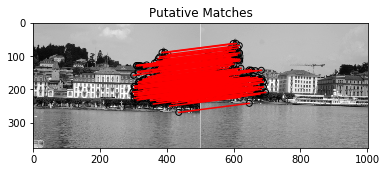

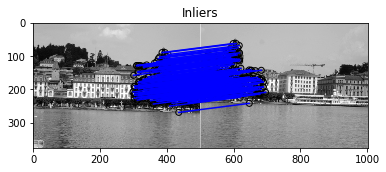

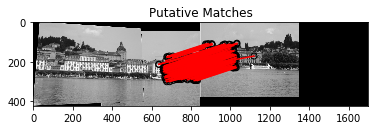

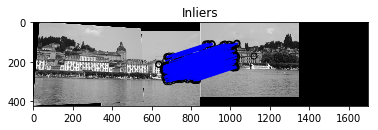

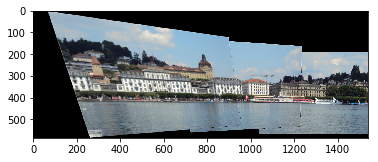

In [25]:
stitch_obj = stitch("files/file1.txt")
warped = stitch_obj.stitchn(verbose=True)
plt.figure()
plt.imshow(warped.astype("uint8"))
plt.show()

Stitching : ['./data/ledge/1.jpg', './data/ledge/2.jpg', './data/ledge/3.jpg']
Number of putative matches:  148
Average inliers residual : 0.04578911871690938
Num of inliers : 148
Number of putative matches:  68
Average inliers residual : -0.043394272363189185
Num of inliers : 68


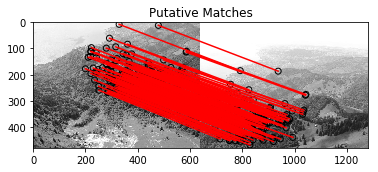

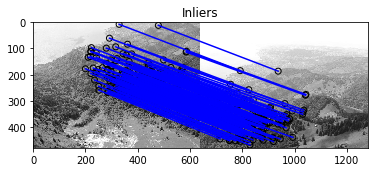

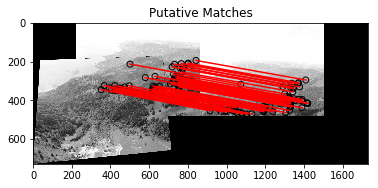

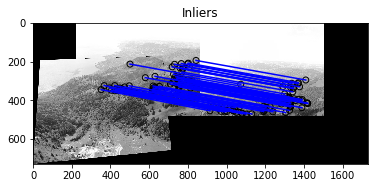

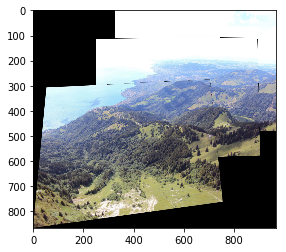

In [26]:
stitch_obj = stitch("files/file2.txt")
warped = stitch_obj.stitchn(verbose=True)
plt.figure()
plt.imshow(warped.astype("uint8"))
plt.show()

Stitching : ['./data/hill/1.jpg', './data/hill/2.jpg', './data/hill/3.jpg']
Number of putative matches:  256
Average inliers residual : -0.3232662359552955
Num of inliers : 256
Number of putative matches:  325
Average inliers residual : -0.1308570037533521
Num of inliers : 325


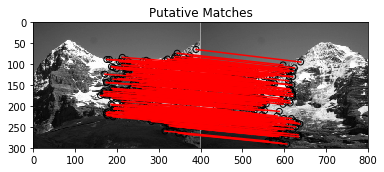

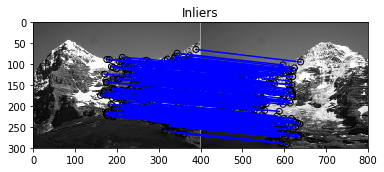

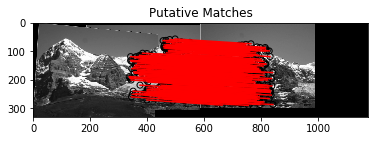

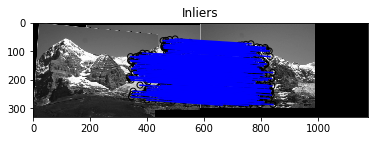

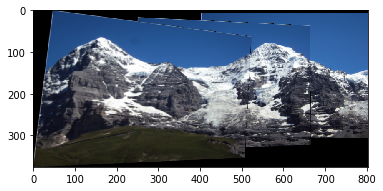

In [27]:
stitch_obj = stitch("files/file3.txt")
warped = stitch_obj.stitchn(verbose=True)
plt.figure()
plt.imshow(warped.astype("uint8"))
plt.show()

Stitching : ['./data/park/1.jpg', './data/park/2.jpg']
Number of putative matches:  13
Average inliers residual : -0.002256657670313997
Num of inliers : 9


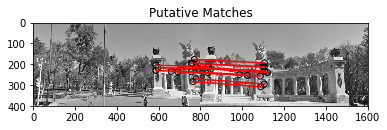

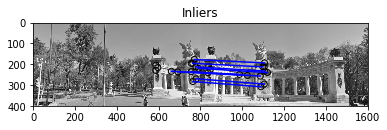

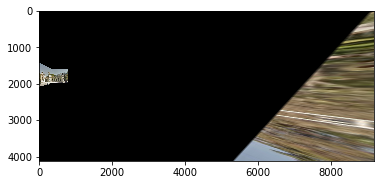

In [7]:
stitch_obj = stitch("files/file4.txt")
warped = stitch_obj.stitchn(verbose=True)
plt.figure()
plt.imshow(warped.astype("uint8"))
plt.show()

In [29]:
# Part 2

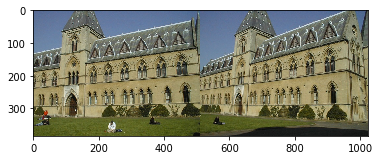

Average residual : 0.36957430463632523


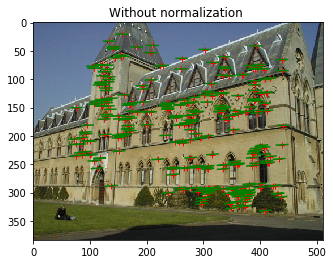

c:\users\34658\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log


Average residual : 0.05017954860340517


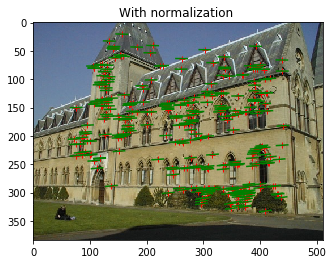

In [51]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import random
##
## load images and match files for the first example
##

I1 = Image.open('library1.jpg');
I2 = Image.open('library2.jpg');
matches = np.loadtxt('library_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3).astype("uint8"))
# ax.plot(matches[:,0],matches[:,1],  '+r')
# ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
# ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()
##
## display second image with epipolar lines reprojected 
## from the first image
##
def fit_fundamental(matches, l_size=None, r_size=None):
    def ransac_fundamental(indices, threshold, max_iterations=300000):
        '''
        @indices: a N x 2 x 2 matrix, where each line is x' and x. We want to \
        find the least square solution of lambda x' = Hx
        @threshold: the maximum distance of inliers
        '''
        def augment(data):
            aug_data = np.ones((len(data), 3), dtype=np.float64)
            aug_data[:,:2] = data
            return aug_data
        
        def is_inlier(model, x, x_p, threshold=threshold):
            L1 = (x @ model.T).reshape(-1, 3)
            l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
            L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())
            pt_line_dist = np.multiply(L, x_p).sum(axis = 1)
            
            return np.count_nonzero(pt_line_dist <= threshold)

        num_points = len(indices)
        max_num_inliers = 0
        min_samples = 8
        x, x_p = augment(indices[:,:2]), augment(indices[:,2:])
        
        # Construct A
        A = np.ones((len(matches), 9))
        for i in range(len(matches)):
            A[i] = np.kron(x_p[i], x[i]).reshape(-1)
        # print(A)
        
        # Adaptive RANSAC
        N = float('inf')
        sample_count = 0
        N= 1
        optim_model = None
        optim_inliers_idx = []
        while N > sample_count and sample_count < max_iterations:
            rand_index = random.sample(range(num_points), min_samples)
            
            # Solve for Ah = 0
            # Construct A_sample
            A_sample = np.zeros((min_samples, 9), dtype=np.float64)
            for i in range(min_samples):
                A_sample[i] = A[rand_index[i]]
            
            # Get the eigenvector lf A^TA corresponding to the smallest eigenvalue
            # This is equivalent to get the vector in V (SVD of A) corresponding to the smallest singular value
            model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
            
            # normalize the last element of the model to 1, it seems unnecessary? 
            model /= model[-1][-1]
            # print(model)
            
            num_inliers = is_inlier(model, x, x_p, threshold)
            if num_inliers > max_num_inliers:
                max_num_inliers = num_inliers
                optim_model = model
                N = np.log(0.05) / np.log(1 - np.power(num_inliers / num_points, min_samples))
                
            sample_count += 1
        
        for i in range(num_points):
            if is_inlier(optim_model, x[i], x_p[i], threshold):
#                     print(i)
                    optim_inliers_idx.append(i)
                    
        # Refit all inliers
        A_sample = np.zeros((len(optim_inliers_idx), 9), dtype=np.float64)
        for i in range(len(optim_inliers_idx)):
            A_sample[i] = A[optim_inliers_idx[i]]
        optim_model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
        u, s, vh = np.linalg.svd(optim_model)
        optim_model = u[:, :2] @ np.diag(s[:2]) @ vh[:2, :]

        return optim_model, np.array(optim_inliers_idx)
    
    # Normalization
    if l_size and r_size:
        l_size = np.array(l_size)
        r_size = np.array(r_size)
        hl_size, hr_size = l_size / 2, r_size / 2
        scale_l = np.sqrt((hl_size[0] * (hl_size[0] + 1) * (2 * hl_size[0] + 1) + \
                          hl_size[1] * (hl_size[1] + 1) * (2 * hl_size[1] + 1)) / \
                          (3 * 4 * hl_size[0] * hl_size[1]))
        scale_r = np.sqrt((hr_size[0] * (hr_size[0] + 1) * (2 * hr_size[0] + 1) + \
                          hr_size[1] * (hr_size[1] + 1) * (2 * hr_size[1] + 1)) / \
                          (3 * 4 * hr_size[0] * hr_size[1]))
        T_l = np.array([[1/scale_l, 0, 0],\
                        [0, 1/scale_l, 0],\
                        [0, 0, 1]]) @ \
              np.array([[1, 0, -hl_size[0]],\
                        [0, 1, -hl_size[1]],\
                        [0, 0, 1]])
        
        T_r = np.array([[1/scale_r, 0, 0],\
                        [0, 1/scale_r, 0],\
                        [0, 0, 1]]) @ \
              np.array([[1, 0, -hr_size[0]],\
                        [0, 1, -hr_size[1]],\
                        [0, 0, 1]])
        
        n_matches = np.empty_like(matches)
        n_matches[:,:2] = (T_l @ np.c_[matches[:, :2], np.ones((len(matches), 1))].T).T[:, :2]
        n_matches[:,2:] = (T_r @ np.c_[matches[:, 2:], np.ones((len(matches), 1))].T).T[:, :2]
        model, inliers = ransac_fundamental(n_matches, 1)
#         model, inliers = ransac((n_matches[:,:2], n_matches[:,2:]), FundamentalMatrixTransform, min_samples=8,
#                                   residual_threshold=1, max_trials=1000)
#         model = model.params
        
        return T_r.T @ model @ T_l
    # Without normalization
    else:
        model, inliers = ransac_fundamental(matches, 1)
        return model
# first, fit fundamental matrix to the matches
F = fit_fundamental(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Average residual :", np.mean(pt_line_dist))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype("uint8"))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.title("Without normalization ")
plt.show()


F = fit_fundamental(matches, l_size=I1.size, r_size=I2.size); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Average residual :", np.mean(pt_line_dist))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype("uint8"))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.title("With normalization ")
plt.show()



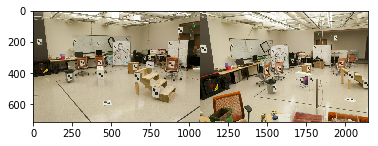

Average residual : -1.7856939642492407


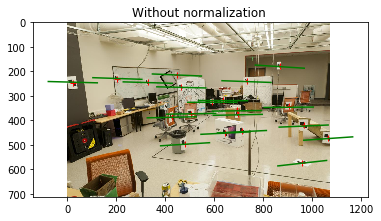

Average residual : -0.15412302270195966


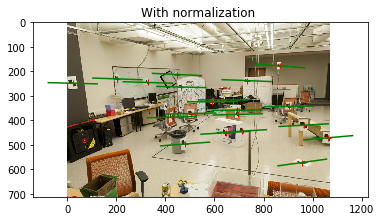

In [52]:
I1 = Image.open('lab1.jpg');
I2 = Image.open('lab2.jpg');
matches = np.loadtxt('lab_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3).astype("uint8"))
# ax.plot(matches[:,0],matches[:,1],  '+r')
# ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
# ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()
##
## display second image with epipolar lines reprojected 
## from the first image
##
def fit_fundamental(matches, l_size=None, r_size=None):
    
    def ransac_fundamental(indices, threshold, max_iterations=300000):

        def augment(data):
            aug_data = np.ones((len(data), 3), dtype=np.float64)
            aug_data[:,:2] = data
            return aug_data
        
        def is_inlier(model, x, x_p, threshold=threshold):
            L1 = (x @ model.T).reshape(-1, 3)
            l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
            L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())
            pt_line_dist = np.multiply(L, x_p).sum(axis = 1)
            
            return np.count_nonzero(pt_line_dist <= threshold)

        num_points = len(indices)
        max_num_inliers = 0
        min_samples = 8
        x, x_p = augment(indices[:,:2]), augment(indices[:,2:])
        
        # Construct A
        A = np.ones((len(matches), 9))
        for i in range(len(matches)):
            A[i] = np.kron(x_p[i], x[i]).reshape(-1)
        # print(A)
        
        # Adaptive RANSAC
        N = float('inf')
        sample_count = 0
        N= 1
        optim_model = None
        optim_inliers_idx = []
        while N > sample_count and sample_count < max_iterations:
            rand_index = random.sample(range(num_points), min_samples)
            
            # Solve for Ah = 0
            # Construct A_sample
            A_sample = np.zeros((min_samples, 9), dtype=np.float64)
            for i in range(min_samples):
                A_sample[i] = A[rand_index[i]]
            
            # Get the eigenvector lf A^TA corresponding to the smallest eigenvalue
            # This is equivalent to get the vector in V (SVD of A) corresponding to the smallest singular value
            model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
            
            # normalize the last element of the model to 1, it seems unnecessary? 
            model /= model[-1][-1]
            # print(model)
            
            num_inliers = is_inlier(model, x, x_p, threshold)
            if num_inliers > max_num_inliers:
                max_num_inliers = num_inliers
                optim_model = model
                N = np.log(0.05) / np.log(1 - np.power(num_inliers / num_points, min_samples))
                
            sample_count += 1
        
        for i in range(num_points):
            if is_inlier(optim_model, x[i], x_p[i], threshold):
#                     print(i)
                    optim_inliers_idx.append(i)
                    
        # Refit all inliers
        A_sample = np.zeros((len(optim_inliers_idx), 9), dtype=np.float64)
        for i in range(len(optim_inliers_idx)):
            A_sample[i] = A[optim_inliers_idx[i]]
        optim_model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 3))
        u, s, vh = np.linalg.svd(optim_model)
        optim_model = u[:, :2] @ np.diag(s[:2]) @ vh[:2, :]
        return optim_model, np.array(optim_inliers_idx)
    
    # Normalization
    if l_size and r_size:
        l_size = np.array(l_size)
        r_size = np.array(r_size)
        hl_size, hr_size = l_size / 2, r_size / 2
        scale_l = np.sqrt((hl_size[0] * (hl_size[0] + 1) * (2 * hl_size[0] + 1) + \
                          hl_size[1] * (hl_size[1] + 1) * (2 * hl_size[1] + 1)) / \
                          (3 * 4 * hl_size[0] * hl_size[1]))
        scale_r = np.sqrt((hr_size[0] * (hr_size[0] + 1) * (2 * hr_size[0] + 1) + \
                          hr_size[1] * (hr_size[1] + 1) * (2 * hr_size[1] + 1)) / \
                          (3 * 4 * hr_size[0] * hr_size[1]))
        T_l = np.array([[1/scale_l, 0, 0],\
                        [0, 1/scale_l, 0],\
                        [0, 0, 1]]) @ \
              np.array([[1, 0, -hl_size[0]],\
                        [0, 1, -hl_size[1]],\
                        [0, 0, 1]])
        
        T_r = np.array([[1/scale_r, 0, 0],\
                        [0, 1/scale_r, 0],\
                        [0, 0, 1]]) @ \
              np.array([[1, 0, -hr_size[0]],\
                        [0, 1, -hr_size[1]],\
                        [0, 0, 1]])
        
        n_matches = np.empty_like(matches)
        n_matches[:,:2] = (T_l @ np.c_[matches[:, :2], np.ones((len(matches), 1))].T).T[:, :2]
        n_matches[:,2:] = (T_r @ np.c_[matches[:, 2:], np.ones((len(matches), 1))].T).T[:, :2]
        model, inliers = ransac_fundamental(n_matches, 1)
#         model, inliers = ransac((n_matches[:,:2], n_matches[:,2:]), FundamentalMatrixTransform, min_samples=8,
#                                   residual_threshold=1, max_trials=1000)
#         model = model.params
        
        return T_r.T @ model @ T_l
    # Without normalization
    else:
        model, inliers = ransac_fundamental(matches, 1)
        return model
# first, fit fundamental matrix to the matches
F = fit_fundamental(matches); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Average residual :", np.mean(pt_line_dist))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*100# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*100

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype("uint8"))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.title("Without normalization ")
plt.show()


F = fit_fundamental(matches, l_size=I1.size, r_size=I2.size); # this is a function that you should write
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
print("Average residual :", np.mean(pt_line_dist))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*100# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*100

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype("uint8"))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.title("With normalization ")
plt.show()

Projection matrix of camera 1 for lab :
[[-3.09735605e-03 -1.44958329e-04  3.92251765e-04  9.79408295e-01]
 [-2.94133825e-04 -6.42300280e-04  2.76825825e-03  2.01840768e-01]
 [-1.65172111e-06 -2.76865140e-06  6.06513274e-07  1.32889347e-03]]
Projection matrix of camera 2 for lab :
[[ 6.83906547e-03 -3.91877522e-03 -1.36878092e-03 -8.27536220e-01]
 [ 1.51917138e-03  1.04571014e-03 -7.24557169e-03 -5.61295519e-01]
 [ 7.46460321e-06  3.72701463e-06 -1.77986918e-06 -3.35283153e-03]]
Residual of projected 3d points and 2d points on camera 1 for lab : 0.9646197523040803
Residual of projected 3d points and 2d points on camera 2 for lab : 1.0901971282421774
Residual of 3d points of lab : 0.0002474048032928939
Residual of projected triangulation 3d points and 2d points on camera 1 for library : 0.07981252814520781
Residual of projected triangulation 3d points and 2d points on camera 2 for library : 0.09271695059954961


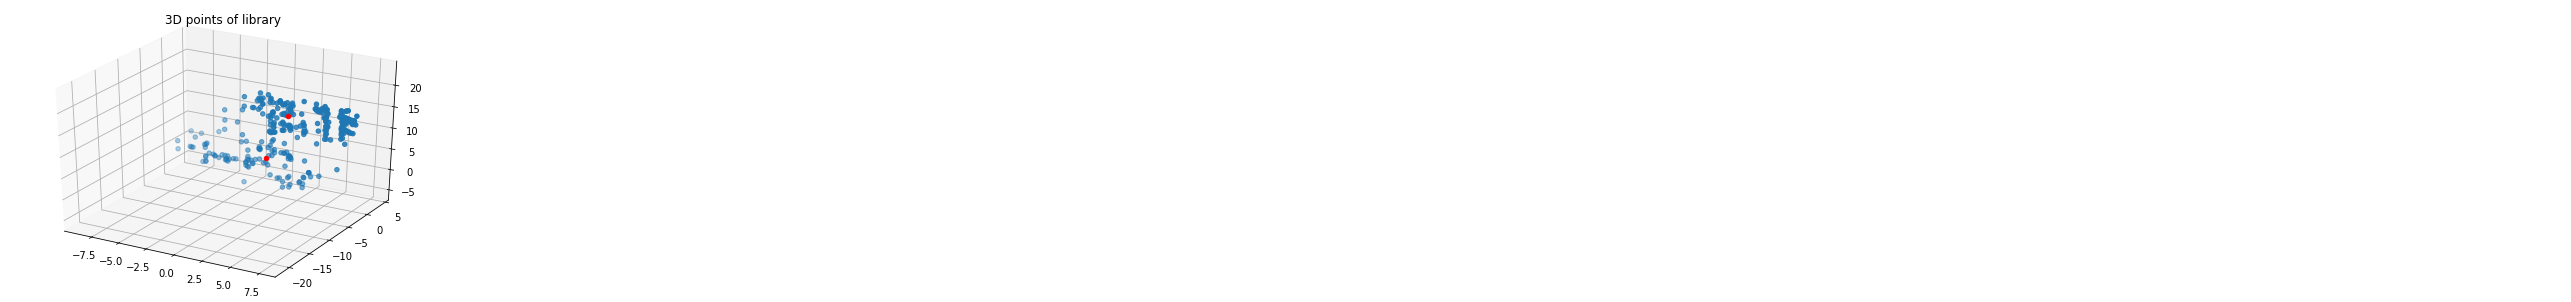

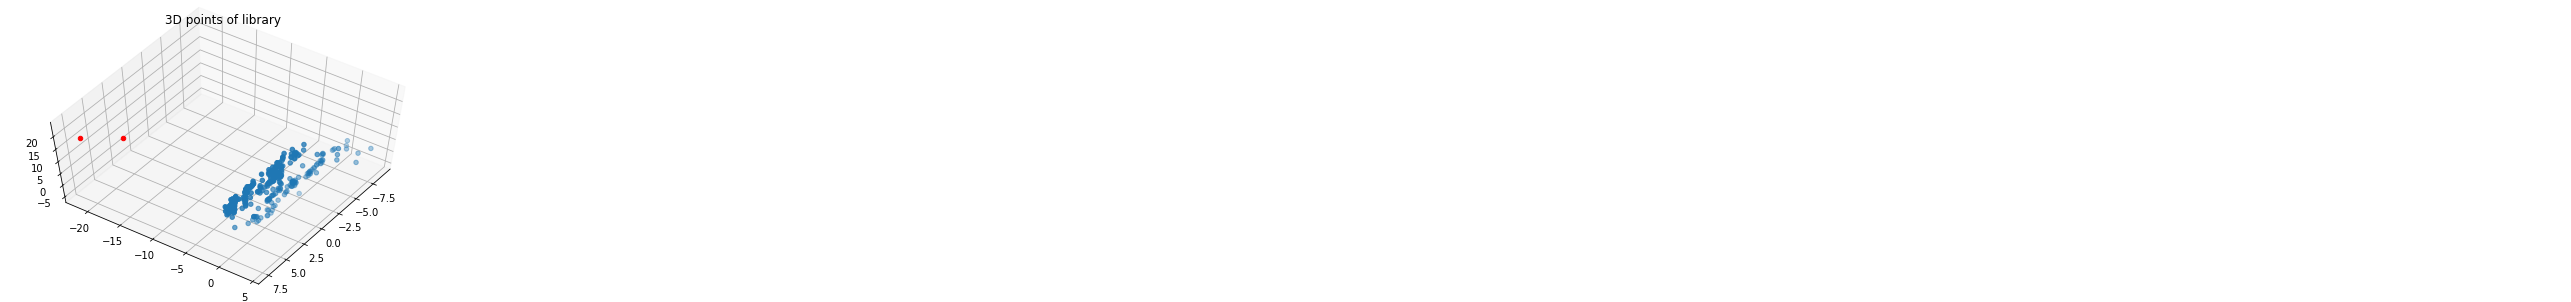

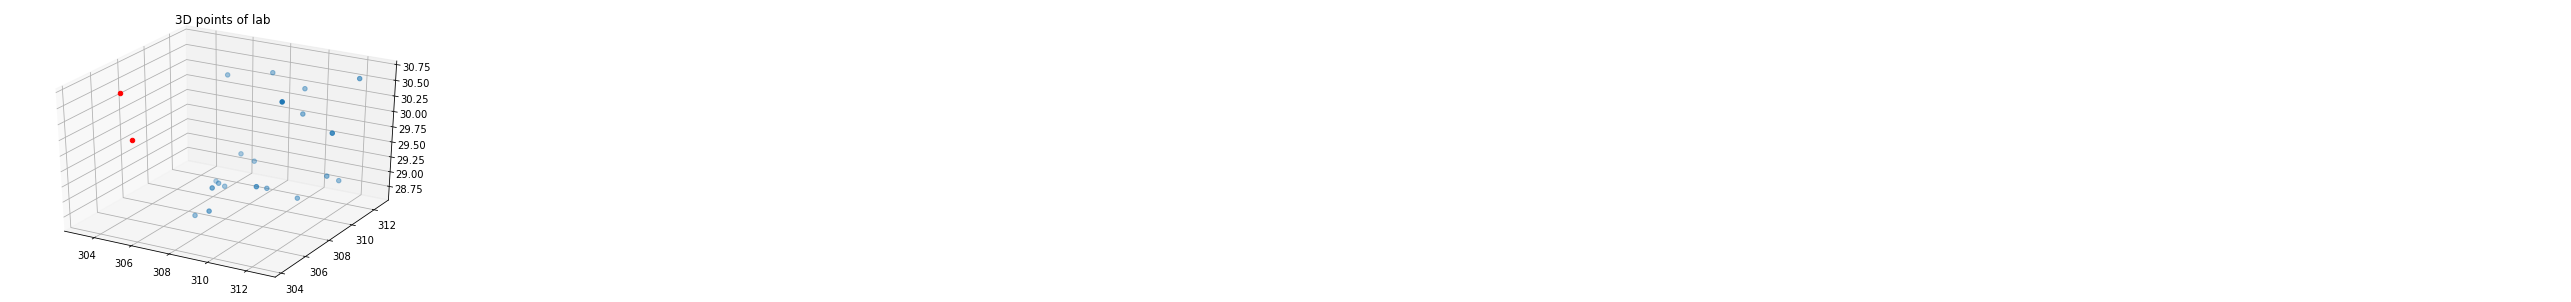

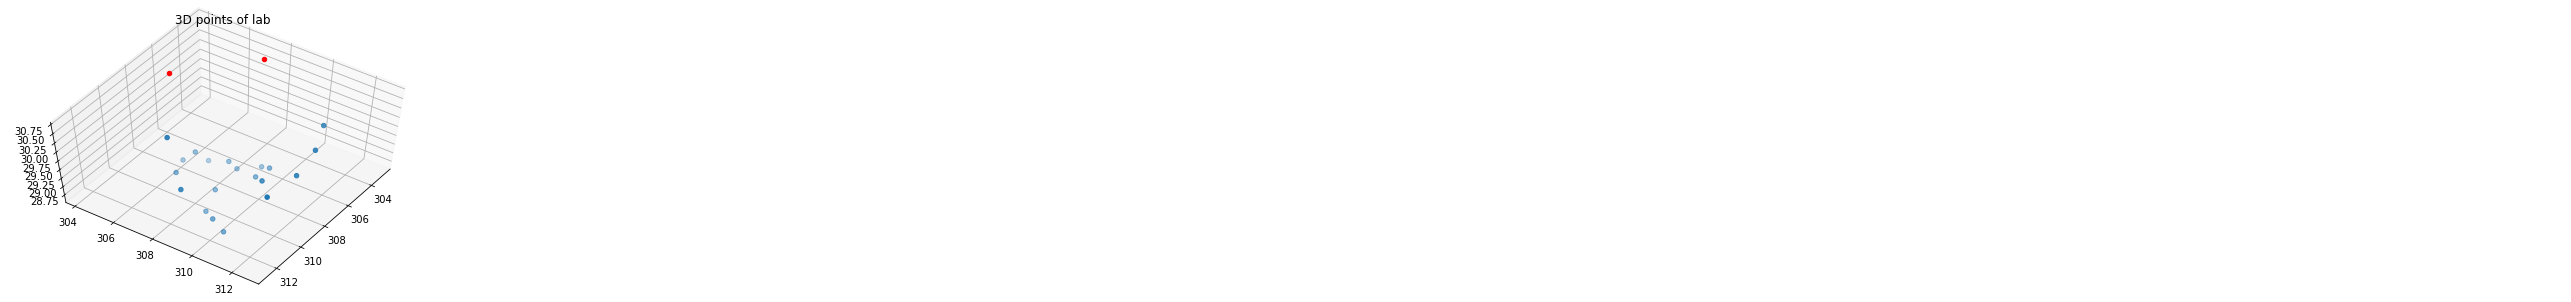

In [53]:
from mpl_toolkits.mplot3d import Axes3D

def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

def ransac_calibration(indices, threshold, max_iterations=300000):
    
    def augment(data):
        aug_data = np.ones((data.shape[0], data.shape[1]+1), dtype=np.float64)
        aug_data[:,:data.shape[1]] = data
        return aug_data

    def is_inlier(model, x, x_p, threshold=threshold):
        tf_x = model @ x
        tf_x /= tf_x[-1]
        return np.sum((tf_x - x_p)**2) <= threshold**2
        
    num_points = len(indices)
    max_num_inliers = 0
    min_samples = 6
    x_p, x = augment(indices[:,:2]), augment(indices[:,2:])
    
    # Construct A
    A = np.zeros((2*len(x), 12), dtype=np.float64)
    for i in range(len(x)):
        A[2*i][4:] = np.hstack((x[i], -x_p[i][1]*x[i]))
        A[2*i+1][:4] = x[i]
        A[2*i+1][8:] = -x_p[i][0]*x[i]
    # print(A)
    
    # Adaptive RANSAC
    N = float('inf')
    sample_count = 0
    N= 1
    optim_model = None
    optim_inliers_idx = []
    while N > sample_count and sample_count < max_iterations:
        rand_index = random.sample(range(num_points), min_samples)
        
        # Solve for Ah = 0
        # Construct A_sample
        A_sample = np.zeros((2 * min_samples, 12), dtype=np.float64)
        for i in range(min_samples):
            A_sample[2*i:2*i+2] = A[2*rand_index[i]:2*rand_index[i]+2]
        
        # Get the eigenvector lf A^TA corresponding to the smallest eigenvalue
        # This is equivalent to get the vector in V (SVD of A) corresponding to the smallest singular value
        model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 4))
        
        # normalize the last element of the model to 1, it seems unnecessary? 
        model /= model[-1][-1]
        # print(model)
        
        num_inliers = 0
        for i in range(num_points):
            if is_inlier(model, x[i], x_p[i], threshold):
                num_inliers += 1
        
        if num_inliers > max_num_inliers:
            max_num_inliers = num_inliers
            optim_model = model
            N = np.log(0.05) / np.log(1 - np.power(num_inliers / num_points, min_samples))
        sample_count += 1
    
    
    for i in range(num_points):
        if is_inlier(optim_model, x[i], x_p[i], threshold):
                optim_inliers_idx.append(i)
                
    # Refit all inliers
    A_sample = np.zeros((2 * len(optim_inliers_idx), 12), dtype=np.float64)
    for i in range(len(optim_inliers_idx)):
        A_sample[2*i:2*i+2] = A[2*optim_inliers_idx[i]:2*optim_inliers_idx[i]+2]
    optim_model = np.linalg.svd(A_sample)[-1][-1,:].reshape((3, 4))
        
    return optim_model, np.array(optim_inliers_idx)


lab_matches = np.loadtxt("lab_matches.txt")
lib_matches = np.loadtxt("library_matches.txt")
lab_3d = np.loadtxt('lab_3d.txt')

lab_P1, _ = ransac_calibration(np.c_[lab_matches[:, :2], lab_3d], 2)
lab_P2, _ = ransac_calibration(np.c_[lab_matches[:, 2:], lab_3d], 2)
print("Projection matrix of camera 1 for lab :")
print(lab_P1)
print("Projection matrix of camera 2 for lab :")
print(lab_P2)

_, res = evaluate_points(lab_P1, lab_matches[:, :2], lab_3d)
print("Residual of projected 3d points and 2d points on camera 1 for lab :", res / len(lab_matches))
_, res = evaluate_points(lab_P2, lab_matches[:, 2:], lab_3d)
print("Residual of projected 3d points and 2d points on camera 2 for lab :", res / len(lab_matches))

_, _, vh_lab1 = np.linalg.svd(lab_P1)
_, _, vh_lab2, = np.linalg.svd(lab_P2)
center_lab1, center_lab2 = vh_lab1[-1], vh_lab2[-1]
center_lab1 /= center_lab1[-1]
center_lab2 /= center_lab2[-1]

lib_P1 = np.loadtxt("library1_camera.txt")
lib_P2 = np.loadtxt("library2_camera.txt")
_, _, vh_lib1 = np.linalg.svd(lib_P1)
_, _, vh_lib2 = np.linalg.svd(lib_P2)
center_lib1, center_lib2 = vh_lib1[-1], vh_lib2[-1]
center_lib1 /= center_lib1[-1]
center_lib2 /= center_lib2[-1]


def triangulation(matches, Ps):
    C = Ps.shape[0]
    N = matches.shape[0]
    points_3d = np.empty((N, 3))
    for i in range(N):
        X = np.empty((2 * C, 4))
        for j in range(C):
            X[2 * j:2 * j + 2] = np.array([[0, -1, matches[i][2 * j + 1]],\
                                 [1, 0, -matches[i][2 * j]]]) @ Ps[j]
#         print(matches[0])
#         print(Ps[0])
#         print(Ps[1])
#         print(X)
        x3d_homo = np.linalg.svd(X)[-1][-1, :]
        x3d_homo /= x3d_homo[-1]
        points_3d[i] = x3d_homo[:3]
    return points_3d
        
    

P_lab = np.stack((lab_P1, lab_P2))
lab_3d_estimate = triangulation(lab_matches, P_lab)
lab_3d_residual = np.mean((lab_3d_estimate - lab_3d) ** 2)
print("Residual of 3d points of lab :", lab_3d_residual)

P_lib = np.stack((lib_P1, lib_P2))
lib_3d_estimate = triangulation(lib_matches, P_lib)

_, lib_2d_residual1 = evaluate_points(lib_P1, lib_matches[:, :2], lib_3d_estimate)
_, lib_2d_residual2 = evaluate_points(lib_P2, lib_matches[:, 2:], lib_3d_estimate)

print("Residual of projected triangulation 3d points and 2d points on camera 1 for library :", lib_2d_residual1 / lib_matches.shape[0])
print("Residual of projected triangulation 3d points and 2d points on camera 2 for library :", lib_2d_residual2 / lib_matches.shape[0])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lib_3d_estimate[:, 0], lib_3d_estimate[:, 1], lib_3d_estimate[:, 2])
ax.scatter(center_lib1[0], center_lib1[1], center_lib1[2], c='r')
ax.scatter(center_lib2[0], center_lib2[1], center_lib2[2], c='r')
plt.title("3D points of library")
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lib_3d_estimate[:, 0], lib_3d_estimate[:, 1], lib_3d_estimate[:, 2])
ax.scatter(center_lib1[0], center_lib1[1], center_lib1[2], c='r')
ax.scatter(center_lib2[0], center_lib2[1], center_lib2[2], c='r')
ax.view_init(60, 35)
plt.title("3D points of library")
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lab_3d_estimate[:, 0], lab_3d_estimate[:, 1], lab_3d_estimate[:, 2])
ax.scatter(center_lab1[0], center_lab1[1], center_lab1[2], c='r')
ax.scatter(center_lab2[0], center_lab2[1], center_lab2[2], c='r')
plt.title("3D points of lab")
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lab_3d_estimate[:, 0], lab_3d_estimate[:, 1], lab_3d_estimate[:, 2])
ax.scatter(center_lab1[0], center_lab1[1], center_lab1[2], c='r')
ax.scatter(center_lab2[0], center_lab2[1], center_lab2[2], c='r')
ax.view_init(60, 35)
plt.title("3D points of lab")
plt.show()

In [2]:
# Part 3

# Single-View Geometry (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

# Common imports

In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# Provided functions

In [2]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.imshow(im)
    print('Set at least %d lines to compute vanishing point' % min_lines)
    while True:
        print('Click the two endpoints, use the right key to undo, and use the middle key to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print('Need at least %d lines, you have %d now' % (min_lines, n))
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [3]:
def plot_lines_and_vp(im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10

    plt.figure()
    plt.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    plt.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    plt.show()

In [4]:
def get_top_and_bottom_coordinates(im, obj):
    """
    For a specific object, prompts user to record the top coordinate and the bottom coordinate in the image.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        obj: string, object name
    Returns:
        coord: np.ndarray of shape (3, 2)
            where coord[:, 0] is the homogeneous coordinate of the top of the object and coord[:, 1] is the homogeneous
            coordinate of the bottom
    """
    plt.figure()
    plt.imshow(im)

    print('Click on the top coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x1, y1 = clicked[0]
    # Uncomment this line to enable a vertical line to help align the two coordinates
    # plt.plot([x1, x1], [0, im.shape[0]], 'b')
    print('Click on the bottom coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x2, y2 = clicked[0]

    plt.plot([x1, x2], [y1, y2], 'b')

    return np.array([[x1, x2], [y1, y2], [1, 1]])

# Your implementation

In [5]:
def get_vanishing_point(n, lines):
    """
    Solves for the vanishing point using the user-input lines.
    """
    # <YOUR IMPLEMENTATION>
    vp = np.zeros(3)
    for i in range(n):
        for j in range(i, n):
            vp += np.cross(lines[:, i], lines[:, j])
    vp /= n
    print(vp)
    return vp

In [6]:
def get_horizon_line(vpts):
    """
    Calculates the ground horizon line.
    """
    # <YOUR IMPLEMENTATION>
    line = np.cross(vpts[:, 0], vpts[:, 1])
    line /= np.sqrt(line[0] ** 2 + line[1] ** 2)
    return line
    

In [7]:
def plot_horizon_line(im, line):
    """
    Plots the horizon line.
    """
    # <YOUR IMPLEMENTATION>
    plt.figure()
    plt.imshow(im)
    pt1 = np.cross(np.array([1, 0, 0]), line)
    pt2 = np.cross(np.array([1, 0, -im.shape[1]]), line)
    
    pt1 /= pt1[-1]
    pt2 /= pt2[-1]

    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')
    plt.show()
    clicked = plt.ginput(2, timeout=0, show_clicks=True)

In [8]:
def get_camera_parameters(vpts):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    from sympy import Symbol, Matrix, solve
    # <YOUR IMPLEMENTATION>
    f = Symbol("f", positive=True)
    px = Symbol("px", positive=True)
    py = Symbol("py", positive=True)

    K_inv = Matrix([[1/f, 0, -px/f],\
                [0, 1/f, -py/f],\
                [0, 0, 1]])
    v1 = Matrix(vpts[:, 0])
    v2 = Matrix(vpts[:, 1])
    v3 = Matrix(vpts[:, 2])
    sol = solve([v1.T * K_inv.T * K_inv * v2, v1.T * K_inv.T * K_inv * v3, v2.T * K_inv.T * K_inv * v3], dict=True)

    return float(sol[0][f]), float(sol[0][px]), float(sol[0][py])

In [9]:
def get_rotation_matrix(vpts, K_inv):
    """
    Computes the rotation matrix using the camera parameters.
    """
    # <YOUR IMPLEMENTATION>
    r1 = K_inv @ vpts[:, 0]
    r2 = K_inv @ vpts[:, 1]
    r3 = K_inv @ vpts[:, 2]
    
    r1 /= np.sqrt(r1[0] ** 2 + r1[1] ** 2 + r1[2] ** 2)
    r2 /= np.sqrt(r2[0] ** 2 + r2[1] ** 2 + r2[2] ** 2)
    r3 /= np.sqrt(r3[0] ** 2 + r3[1] ** 2 + r3[2] ** 2)
    
    return np.c_[r2, r3, r1]

In [10]:
def estimate_height(target_coord, horizon_line, ref_coord, ref_height, im):
    """
    Estimates height for a specific object using the recorded coordinates. You might need to plot additional images here for
    your report.
    """
    # <YOUR IMPLEMENTATION>
    
    def get_dist(pt1, pt2):
        return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)
    target_line = np.cross(target_coord[:, 0], target_coord[:, 1])
    parallel_l1 = np.cross(target_coord[:, 1], ref_coord[:, 1])
    
    v = np.cross(parallel_l1, horizon_line)
    v /= v[-1]
    
    parallel_l2 = np.cross(ref_coord[:, 0], v)
    t = np.cross(parallel_l2, target_line)
    t /= t[-1]
    
    plt.figure()
    plt.imshow(im)
    pt1 = np.cross(np.array([1, 0, 0]), horizon_line)
    pt2 = np.cross(np.array([1, 0, -im.shape[1]]), horizon_line)
    
    pt1 /= pt1[-1]
    pt2 /= pt2[-1]

    # Plot reference object
    plt.plot([ref_coord[0, 0], ref_coord[0, 1]], [ref_coord[1, 0], ref_coord[1, 1]], color='w')
    # Plot target object
    plt.plot([target_coord[0, 0], target_coord[0, 1]], [target_coord[1, 0], target_coord[1, 1]], color='w')
    # Plot horizon line
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')
    # Plot bottom parallel line 
    plt.plot([target_coord[0, 1], v[0]], [target_coord[1, 1], v[1]], color='r')
    # Plot top parallel line 
    plt.plot([t[0], v[0]], [t[1], v[1]], color='r')
    plt.axis('off')
    clicked = plt.ginput(2, timeout=0, show_clicks=True)
    
    rb = get_dist(target_coord[:, 0], target_coord[:, 1])
    rt = get_dist(target_coord[:, 0], t)
    target_height = ref_height * rb / (rb - rt)
    
    
    return target_height

# Main function

In [11]:
im = np.asarray(Image.open('CSL.jpg'))

# Part 1
# Get vanishing points for each of the directions
num_vpts = 3
vpts = np.zeros((3, num_vpts))
for i in range(num_vpts):
    print('Getting vanishing point %d' % i)
    # Get at least three lines from user input
    n, lines, centers = get_input_lines(im)
    # <YOUR IMPLEMENTATION> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(n, lines)
    # Plot the lines and the vanishing point
    plot_lines_and_vp(im, lines, vpts[:, i])
    
# vpts = np.array([[-1027475.66514183,   708045.23131104,     3450.17444923],\
# [-3.03153057e+06, -5.20304935e+05, -2.28455359e+03],\
# [-2.94804282e+05, -7.81460621e+06, -7.91999243e+02]]).T

# <YOUR IMPLEMENTATION> Get the ground horizon line
horizon_line = get_horizon_line(vpts[:, :2])
# # <YOUR IMPLEMENTATION> Plot the ground horizon line
plot_horizon_line(im, horizon_line)

# Part 2
# <YOUR IMPLEMENTATION> Solve for the camera parameters (f, u, v)
f, u, v = get_camera_parameters(vpts)
K_inv = np.array([[1/f, 0, -u/f],\
                  [0, 1/f, -v/f],\
                  [0, 0, 1]])

# Part 3
# <YOUR IMPLEMENTATION> Solve for the rotation matrix
R = get_rotation_matrix(vpts, K_inv)

# Part 4
# Record image coordinates for each object and store in map
objects = ('person', 'CSL building', 'the spike statue', 'the lamp posts', 'man_in_red')
coords = dict()
for obj in objects:
    coords[obj] = get_top_and_bottom_coordinates(im, obj)
# coords = {'person': np.array([[625.73655914, 625.73655914],
#        [466.66810036, 510.25232975],
#        [  1.        ,   1.        ]]), 'CSL building': np.array([[829.89426523, 820.71863799],
#        [124.87598566, 365.73620072],
#        [  1.        ,   1.        ]]), 'the spike statue': np.array([[601.65053763, 602.79749104],
#        [253.33476703, 474.69677419],
#        [  1.        ,   1.        ]]), 'the lamp posts': np.array([[1.00537814e+03, 9.93908602e+02],
#        [3.66883154e+02, 4.80431541e+02],
#        [1.00000000e+00, 1.00000000e+00]]), 'man_in_red': np.array([[469.75089606, 469.75089606],
#        [519.42795699, 576.77562724],
#        [  1.        ,   1.        ]])}
# <YOUR IMPLEMENTATION> Estimate heights
print(coords)
for obj in objects[1:]:
    print('Estimating height of %s' % obj)
    height = estimate_height(coords[obj], horizon_line, coords['person'], 1.6764, im)
    print(height)
for obj in objects[1:]:
    print('Estimating height of %s' % obj)
    height = estimate_height(coords[obj], horizon_line, coords['person'], 1.8288, im)
    print(height)

Getting vanishing point 0
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the rig

c:\users\34658\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
c:\users\34658\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
c:\users\34658\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
c:\users\34658\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Click on the top coordinate of person
Click on the bottom coordinate of person
Click on the top coordinate of CSL building
Click on the bottom coordinate of CSL building
Click on the top coordinate of the spike statue
Click on the bottom coordinate of the spike statue
Click on the top coordinate of the lamp posts
Click on the bottom coordinate of the lamp posts
Click on the top coordinate of man_in_red
Click on the bottom coordinate of man_in_red
{'person': array([[625.73655914, 625.73655914],
       [466.66810036, 512.54623656],
       [  1.        ,   1.        ]]), 'CSL building': array([[828.74731183, 820.71863799],
       [132.9046595 , 364.58924731],
       [  1.        ,   1.        ]]), 'the spike statue': array([[601.65053763, 602.79749104],
       [252.18781362, 473.54982079],
       [  1.        ,   1.        ]]), 'the lamp posts': array([[1.00537814e+03, 9.95055556e+02],
       [3.65736201e+02, 4.80431541e+02],
       [1.00000000e+00, 1.00000000e+00]]), 'man_in_red': array(

In [21]:
print(f, u, v)
print(R)
print(horizon_line)

746.6196753948349 559.6766231525515 287.5566684306717
[[-0.74759214 -0.66410722  0.00822129]
 [-0.06908874  0.06545062 -0.99546118]
 [ 0.66055487 -0.74476696 -0.0948127 ]]
[ 8.25849181e-03 -9.99965898e-01  2.11815410e+02]


In [13]:
# f = 809.536095493823
# px = 505.093711298330
# py = 284.745388827713
# K_i = np.array([[1/f, 0, -px/f],\
#                 [0, 1/f, -py/f],\
#                 [0, 0, 1]])
# v1 = vpts[:, 0]
# v2 = vpts[:, 1]
# v3 = vpts[:, 2]

# v2.T @ K_i.T @ K_i @ v3

In [15]:
# {'person': array([[625.0483871 , 625.0483871 ],
#        [465.04516129, 510.46451613],
#        [  1.        ,   1.        ]]), 'CSL building': array([[602.33870968, 598.20967742],
#        [ 52.14193548, 312.27096774],
#        [  1.        ,   1.        ]]), 'the spike statue': array([[602.33870968, 600.27419355],
#        [253.42193548, 474.32516129],
#        [  1.        ,   1.        ]]), 'the lamp posts': array([[1.00491935e+03, 9.92532258e+02],
#        [3.72141935e+02, 4.83625806e+02],
#        [1.00000000e+00, 1.00000000e+00]])}